In [ ]:
# === Install dependencies ===
!pip install hopsworks[python]
!pip install confluent-kafka

In [ ]:
# === Import and load data from Hopsworks ===
import hopsworks

project = hopsworks.login()
fs = project.get_feature_store()

fg_v1 = fs.get_feature_group(name="aqi_weather_features", version=1)
df_raw = fg_v1.read()
df = df_raw.sort_values("time", ascending=True)



To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1239199
Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.47s) 


In [ ]:
df

,time,pm10,pm2_5,carbon_monoxide,carbon_dioxide,nitrogen_dioxide,sulphur_dioxide,ozone,us_aqi,temperature_2m,relative_humidity_2m,rain,wind_speed_10m,wind_direction_10m
22248,2023-01-01 00:00:00+00:00,73.1,49.7,1775.0,NaN,74.4,6.9,26.0,132.0,4.8,85.0,0.0,7.6,315.0
8649,2023-01-01 01:00:00+00:00,66.1,44.4,1495.0,NaN,59.7,6.3,37.0,131.0,4.1,87.0,0.0,7.9,309.0
11707,2023-01-01 02:00:00+00:00,60.8,40.4,1186.0,NaN,41.8,5.9,49.0,130.0,4.2,84.0,0.0,5.4,290.0
13570,2023-01-01 03:00:00+00:00,56.6,37.4,1001.0,NaN,31.0,5.6,56.0,129.0,3.8,85.0,0.0,5.3,298.0
20467,2023-01-01 04:00:00+00:00,53.6,35.4,856.0,NaN,21.3,5.4,61.0,128.0,4.4,81.0,0.0,4.4,305.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22789,2025-08-07 13:00:00+00:00,79.6,43.5,487.0,449.0,4.9,22.6,197.0,102.0,30.5,69.0,0.0,9.2,149.0
22790,2025-08-07 14:00:00+00:00,85.2,45.4,432.0,447.0,5.5,19.3,195.0,104.0,29.5,75.0,0.0,7.4,157.0
22791,2025-08-07 15:00:00+00:00,85.4,44.5,380.0,445.0,3.2,18.3,195.0,116.0,28.5,79.0,0.0,4.6,141.0
22792,2025-08-07 16:00:00+00:00,98.0,50.6,358.0,443.0,1.8,18.1,190.0,145.0,27.9,82.0,0.0,3.9,124.0


In [ ]:
# === Data preparation ===
import pandas as pd
from sklearn.model_selection import train_test_split

df_selected = df[['time', 'pm2_5', 'carbon_monoxide', 'ozone', 'relative_humidity_2m', 'wind_speed_10m','us_aqi']].copy()
df_selected['time'] = pd.to_datetime(df_selected['time'])
df_selected.set_index('time', inplace=True)
df_selected.dropna(inplace=True)

X = df_selected[['pm2_5', 'carbon_monoxide', 'ozone', 'relative_humidity_2m', 'wind_speed_10m']]
y = df_selected['us_aqi']

split_ratio = 0.8
split_point = int(len(df_selected) * split_ratio)
X_train = X.iloc[:split_point]
X_test = X.iloc[split_point:]
y_train = y.iloc[:split_point]
y_test = y.iloc[split_point:]

from sklearn.preprocessing import MinMaxScaler

X_scaler = MinMaxScaler()
X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))

In [ ]:
# === Sequence generation ===
import numpy as np
timesteps = 800
features = ['pm2_5', 'carbon_monoxide', 'ozone', 'relative_humidity_2m', 'wind_speed_10m']

def create_sequences(X_data, y_data, timesteps):
    X_seq, y_seq = [], []
    for i in range(timesteps, len(X_data)):
        X_seq.append(X_data[i - timesteps:i])
        y_seq.append(y_data[i])
    return np.array(X_seq), np.array(y_seq)

X_seq_train, y_seq_train = create_sequences(X_train_scaled, y_train_scaled, timesteps)
X_seq_test, y_seq_test = create_sequences(X_test_scaled, y_test_scaled, timesteps)

In [ ]:
!pip install tensorflow

In [ ]:
# === LSTM Model ===
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping

model = Sequential()
model.add(LSTM(50, return_sequences=True, activation='tanh', input_shape=(timesteps, len(features))))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True, activation='tanh'))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True, activation='tanh'))
model.add(Dropout(0.2))
model.add(LSTM(50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model.fit(
    X_seq_train, y_seq_train,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    callbacks=[early_stop]
)


Epoch 1/20
436/436 ━━━━━━━━━━━━━━━━━━━━ 52s 96ms/step - loss: 0.0205 - val_loss: 0.0043
Epoch 2/20
436/436 ━━━━━━━━━━━━━━━━━━━━ 77s 94ms/step - loss: 0.0049 - val_loss: 0.0014
Epoch 3/20
436/436 ━━━━━━━━━━━━━━━━━━━━ 81s 93ms/step - loss: 0.0030 - val_loss: 0.0015
Epoch 4/20
436/436 ━━━━━━━━━━━━━━━━━━━━ 40s 92ms/step - loss: 0.0021 - val_loss: 0.0010
Epoch 5/20
436/436 ━━━━━━━━━━━━━━━━━━━━ 40s 90ms/step - loss: 0.0018 - val_loss: 8.5334e-04
Epoch 6/20
436/436 ━━━━━━━━━━━━━━━━━━━━ 42s 93ms/step - loss: 0.0014 - val_loss: 5.8097e-04
Epoch 7/20
436/436 ━━━━━━━━━━━━━━━━━━━━ 39s 90ms/step - loss: 0.0012 - val_loss: 8.0972e-04
Epoch 8/20
436/436 ━━━━━━━━━━━━━━━━━━━━ 43s 93ms/step - loss: 0.0010 - val_loss: 5.3055e-04
Epoch 9/20
436/436 ━━━━━━━━━━━━━━━━━━━━ 40s 91ms/step - loss: 8.9309e-04 - val_loss: 4.4796e-04
Epoch 10/20
436/436 ━━━━━━━━━━━━━━━━━━━━ 41s 90ms/step - loss: 8.3867e-04 - val_loss: 3.7372e-04
Epoch 11/20
436/436 ━━━━━━━━━━━━━━━━━━━━ 42s 92ms/step - loss: 8.3927e-04 - val_loss: 4

In [ ]:
# === Predict and inverse transform ===
y_pred_scaled = model.predict(X_seq_test)
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_true = y_scaler.inverse_transform(y_seq_test)


118/118 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step


In [ ]:

# === Evaluation ===
from sklearn.metrics import mean_squared_error, r2_score
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")


RMSE: 3.59
R² Score: 0.99


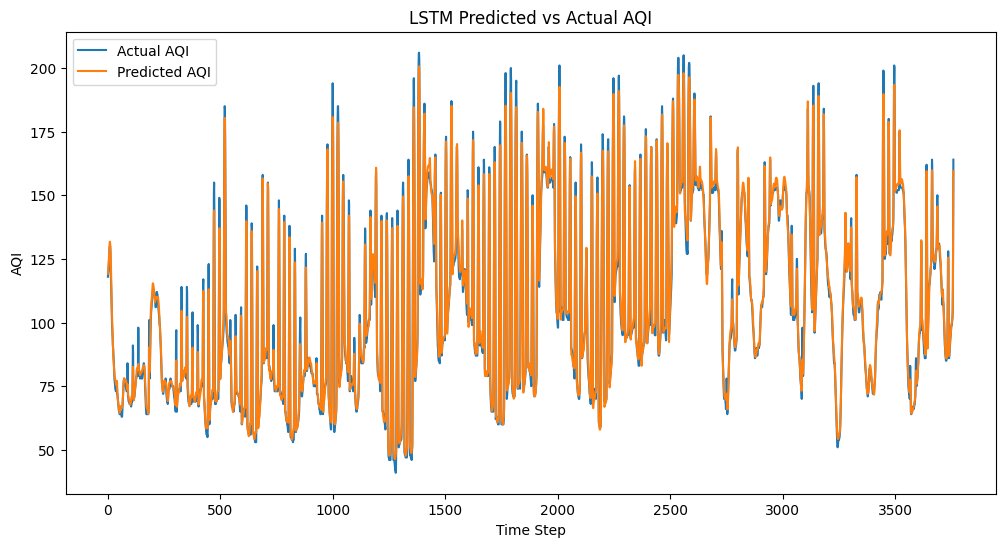

In [ ]:
# === Plot Results ===
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(y_true, label='Actual AQI')
plt.plot(y_pred, label='Predicted AQI')
plt.legend()
plt.title("LSTM Predicted vs Actual AQI")
plt.xlabel("Time Step")
plt.ylabel("AQI")
plt.show()

In [ ]:
# === Save Predictions with Timestamps ===
future_timestamps = df["time"].iloc[timesteps + split_point:].reset_index(drop=True)
pred_df = pd.DataFrame({
    "datetime": future_timestamps,
    "actual_us_aqi": y_true.flatten(),
    "predicted_us_aqi": y_pred.flatten()
})
pred_df.to_csv("lstm_predictions.csv", index=False)

In [ ]:
# X_future = df_features[ ['pm2_5', 'carbon_monoxide', 'ozone', 'relative_humidity_2m', 'wind_speed_10m'] ].values
# X_future_scaled = X_scaler.transform(X_future)


In [ ]:
# # === Forecast next 72 hours ===
# future_steps = 72
# timesteps = 50  # should be same as training
# last_known_inputs = X_test_scaled[-timesteps:].copy()
# predicted_future = []

# for _ in range(future_steps):
#     input_seq = last_known_inputs[-timesteps:].reshape(1, timesteps, len(features))
#     next_scaled_pred = model.predict(input_seq, verbose=0)
#     next_pred = y_scaler.inverse_transform(next_scaled_pred)[0][0]
#     predicted_future.append(next_pred)
# #
#     # Simulate future inputs: using last known features
#     next_input_features = last_known_inputs[-1].copy()
#     last_known_inputs = np.vstack([last_known_inputs[1:], next_input_features])

# # === Save Future Predictions ===
# last_time = df_selected.index[-1]
# future_times = pd.date_range(start=last_time, periods=future_steps + 1, freq='H')[1:]

# future_pred_df = pd.DataFrame({
#     "datetime": future_times,
#     "predicted_us_aqi": predicted_future
# })

# print(future_pred_df.head())
# future_pred_df.to_csv("future_72hr_predictions_lstm.csv", index=False)

                   datetime  predicted_us_aqi
0 2025-08-07 18:00:00+00:00        166.971481
1 2025-08-07 19:00:00+00:00        150.309372
2 2025-08-07 20:00:00+00:00        122.939880
3 2025-08-07 21:00:00+00:00        112.195679
4 2025-08-07 22:00:00+00:00        110.959732


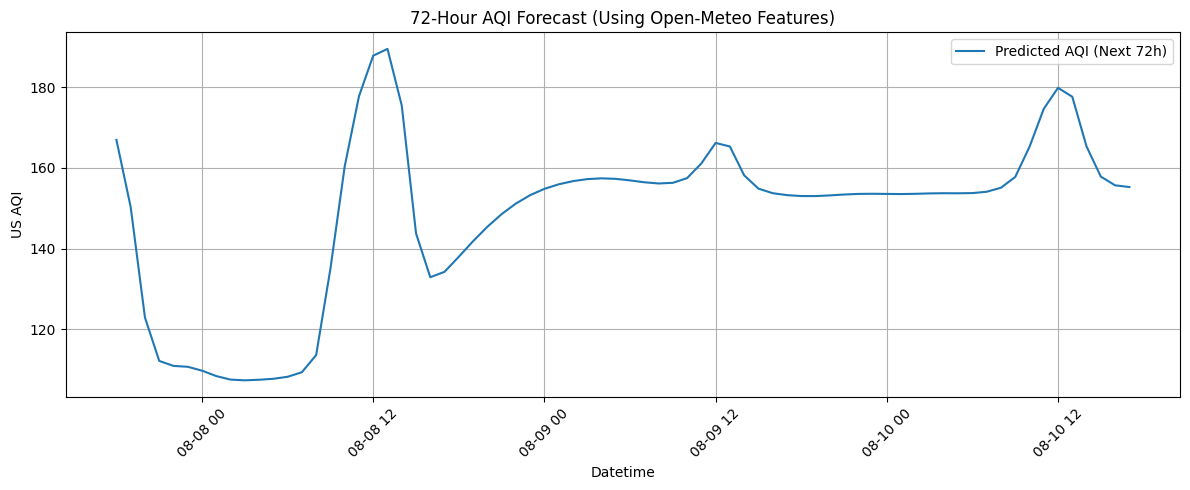

In [ ]:
import requests
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# === Assumes model, X_scaler, y_scaler, and timesteps already exist ===
# You already trained model, and have X_scaler, y_scaler from training

# === Step 1: Fetch Air Quality Forecast (pollutants) ===
air_url = "https://air-quality-api.open-meteo.com/v1/air-quality"
air_params = {
    "latitude": 33.5973,
    "longitude": 73.0479,
    "hourly": "pm2_5,carbon_monoxide,ozone",
    "forecast_days": 4,
    "timezone": "auto"
}
air_resp = requests.get(air_url, params=air_params).json()

# === Step 2: Fetch Weather Forecast (humidity + wind) ===
weather_url = "https://api.open-meteo.com/v1/forecast"
weather_params = {
    "latitude": 33.5973,
    "longitude": 73.0479,
    "hourly": "relative_humidity_2m,wind_speed_10m",
    "forecast_days": 4,
    "timezone": "auto"
}
weather_resp = requests.get(weather_url, params=weather_params).json()

# === Step 3: Combine both forecasts ===
df_pollutants = pd.DataFrame({
    "time": air_resp["hourly"]["time"],
    "pm2_5": air_resp["hourly"]["pm2_5"],
    "carbon_monoxide": air_resp["hourly"]["carbon_monoxide"],
    "ozone": air_resp["hourly"]["ozone"],

})

df_weather = pd.DataFrame({
    "time": weather_resp["hourly"]["time"],
    "relative_humidity_2m": weather_resp["hourly"]["relative_humidity_2m"],
    "wind_speed_10m": weather_resp["hourly"]["wind_speed_10m"],

})

df_future = pd.merge(df_pollutants, df_weather, on="time")
df_future["time"] = pd.to_datetime(df_future["time"])
df_future = df_future.sort_values("time").reset_index(drop=True).iloc[:72]

# === Step 4: Prepare input features ===
features = ['pm2_5', 'carbon_monoxide', 'ozone', 'relative_humidity_2m', 'wind_speed_10m']
X_future = df_future[features].values
X_future_scaled = X_scaler.transform(X_future)

# === Step 5: Start with last known data ===
timesteps = 800
future_steps = 72
last_window = df_selected[-timesteps:]
X_last = last_window[features].values
X_last_scaled = X_scaler.transform(X_last)
input_sequence = X_last_scaled.copy()
predicted_future = []

# === Step 6: Forecast using rolling input with API features ===
for i in range(future_steps):
    input_seq = input_sequence.reshape(1, timesteps, len(features))
    next_scaled_pred = model.predict(input_seq, verbose=0)
    next_pred = y_scaler.inverse_transform(next_scaled_pred)[0][0]
    predicted_future.append(next_pred)

    if i < len(X_future_scaled):
        next_input = X_future_scaled[i]
    else:
        next_input = input_sequence[-1]  # fallback
    input_sequence = np.vstack([input_sequence[1:], next_input])

# === Step 7: Generate timestamps ===
last_time = df_selected.index[-1]
future_times = pd.date_range(start=last_time + pd.Timedelta(hours=1), periods=72, freq='H')

# === Step 8: Save and show result ===
forecast_df = pd.DataFrame({
    "datetime": future_times,
    "predicted_us_aqi": predicted_future
})

forecast_df.to_csv("72hr_forecast_with_api_features.csv", index=False)
print(forecast_df.head())

# === Optional Plot ===
plt.figure(figsize=(12, 5))
plt.plot(forecast_df["datetime"], forecast_df["predicted_us_aqi"], label="Predicted AQI (Next 72h)")
plt.xticks(rotation=45)
plt.title("72-Hour AQI Forecast (Using Open-Meteo Features)")
plt.xlabel("Datetime")
plt.ylabel("US AQI")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
